In [1]:
import os 
from neuron_morphology.swc_io import morphology_from_swc
from morph_utils.visuals import basic_morph_plot
from morph_utils.measurements import leftextent, rightextent, inextent

from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from neuron_morphology.swc_io import *
import os
import warnings


import sys
sys.path.append(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration')
from ccf_slice_registration_functions_withUpright import *

2024-07-17 17:27:24,874 numexpr.utils INFO     NumExpr defaulting to 8 threads.


In [2]:
ccf_reg_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\ccf_reg_output_20240712'
viewer_outfile = os.path.join(ccf_reg_root, 'ccf_reg_output_20240712_viewer.pdf')

Get a dict of all the swcs to view

In [4]:
viewer_cells = {}
for slice_name in os.listdir(ccf_reg_root):
    if os.path.isdir(os.path.join(ccf_reg_root, slice_name, 'SWC')):
        for swc in os.listdir(os.path.join(ccf_reg_root, slice_name, 'SWC')):
            if swc.endswith('_reg.swc'):
                #there's a registered swc, so there should be a corresponding upright swc
                reg_path = os.path.join(ccf_reg_root, slice_name, 'SWC', swc)
                up_path = reg_path.replace('_reg.swc', '_upright.swc')

                if not os.path.isfile(up_path):
                    print('cell {} is registered but not upright : {}'.format(swc, reg_path))
                else:
                    specimen_id = int(swc.split('_',1)[0])
                    slice_id = get_id_by_name(slice_name)
                    #reconstruction type 
                    if 'spiny' in swc.lower(): swc_type = 'autotrace'
                    else: swc_type = 'manual'


                    #add registered swc 
                    reg_type = 'registered'
                    viewer_cells[str(specimen_id) + '_' + swc_type + '_' + reg_type] = {'specimen_id' : specimen_id,'swc_path' : reg_path, 'slice_name' : slice_name, 
                                                                                        'slice_id' : slice_id, 'reg_type' : reg_type, 'swc_type' : swc_type}
                    
                    #add upright swc
                    reg_type = 'uprighted'
                    viewer_cells[str(specimen_id) + '_' + swc_type + '_' + reg_type] = {'specimen_id' : specimen_id,'swc_path' : up_path, 'slice_name' : slice_name, 
                                                                                        'slice_id' : slice_id, 'reg_type' : reg_type, 'swc_type' : swc_type}
                    


In [5]:
len(viewer_cells)

1096

Make the viewer

In [6]:
linew = 0.1 #line width for plotting neurites
compartment_list = [1,2,3,4]
plot_side = [True, False] #true=xy, false=xy for ccf xy=sagittalview yz=coronal view. 

title = ['swc_type', 'reg_type'] #assumed specimen_id is first 
title_font_size = [7, 6, 6]


Sps list is 1096 long


C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_24536\3007954514.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(7.5,10),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},


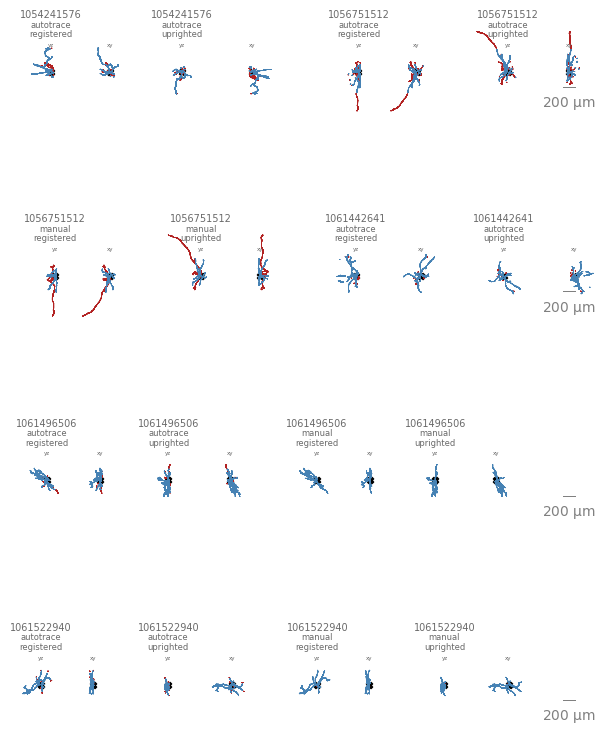

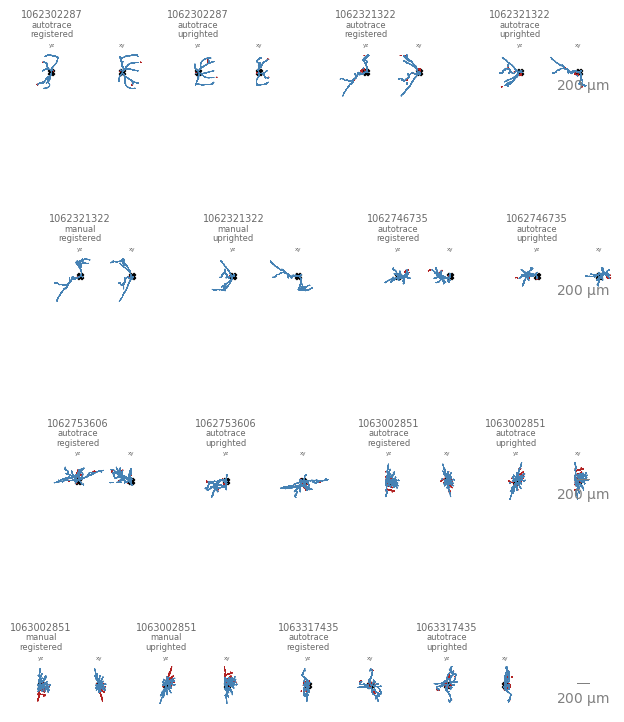

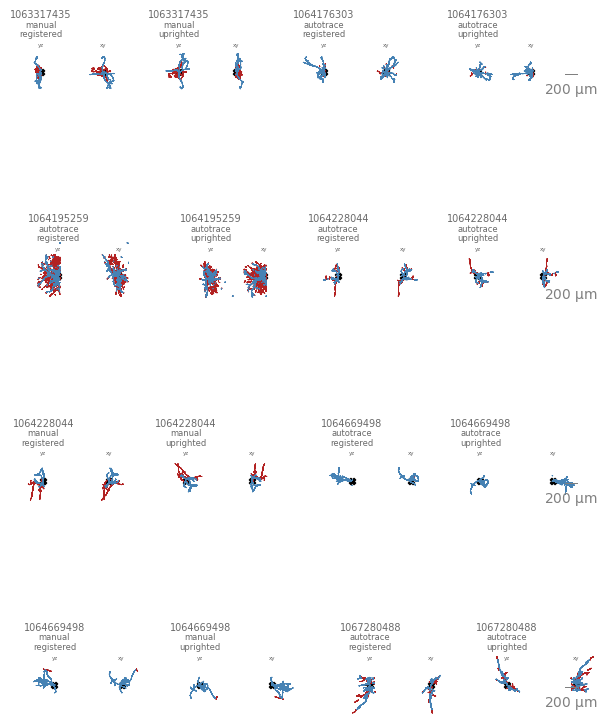

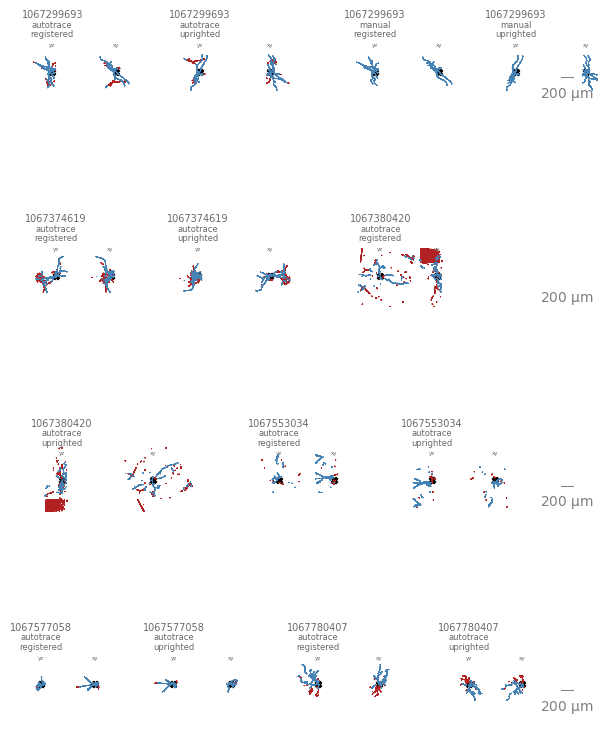

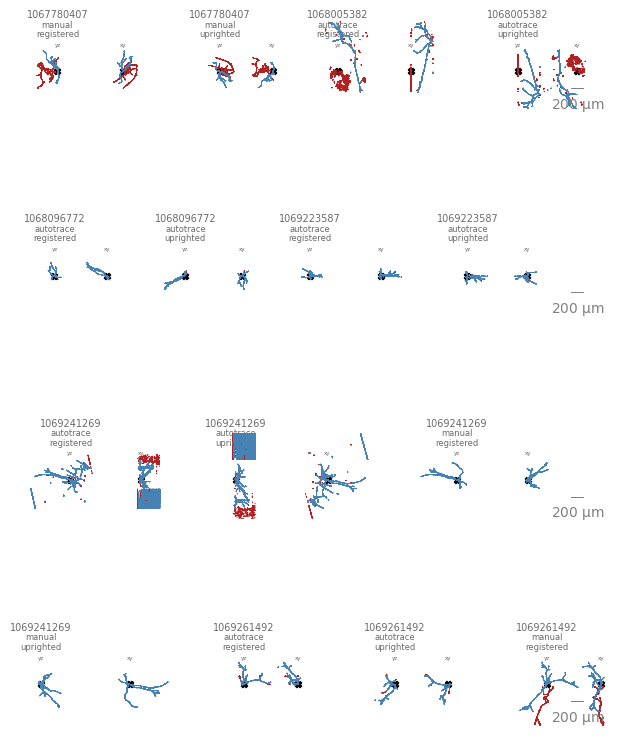

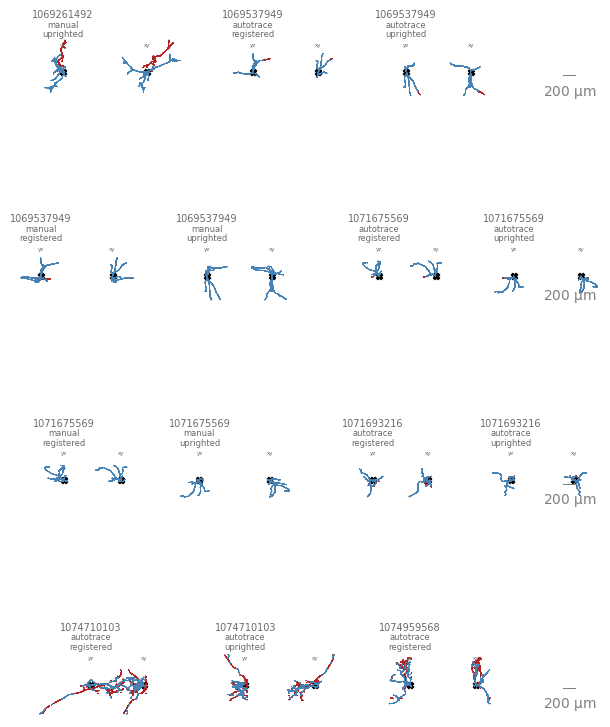

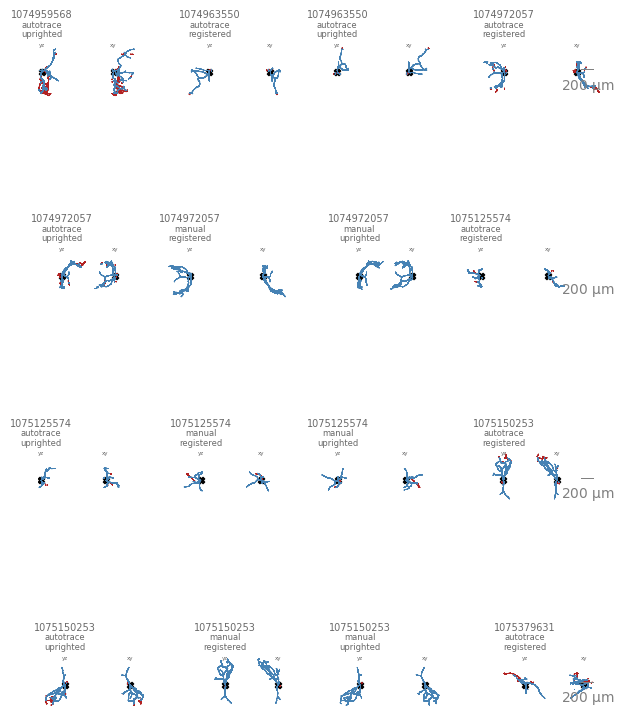

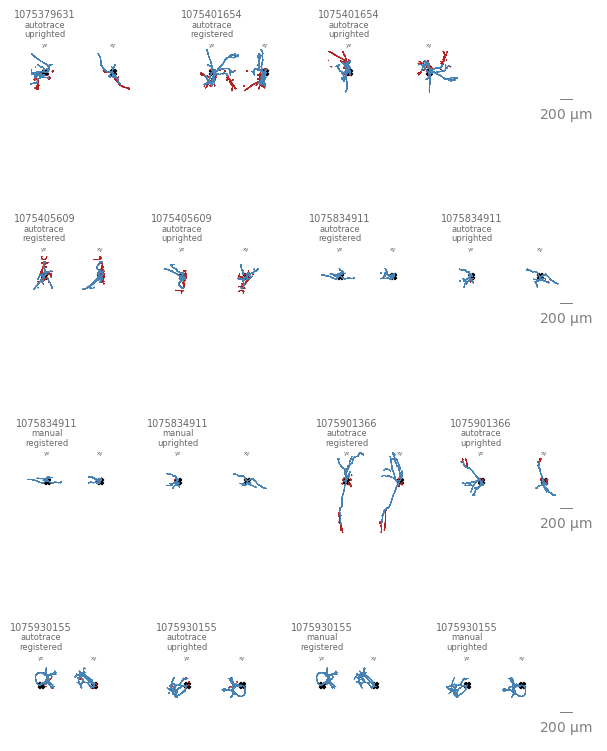

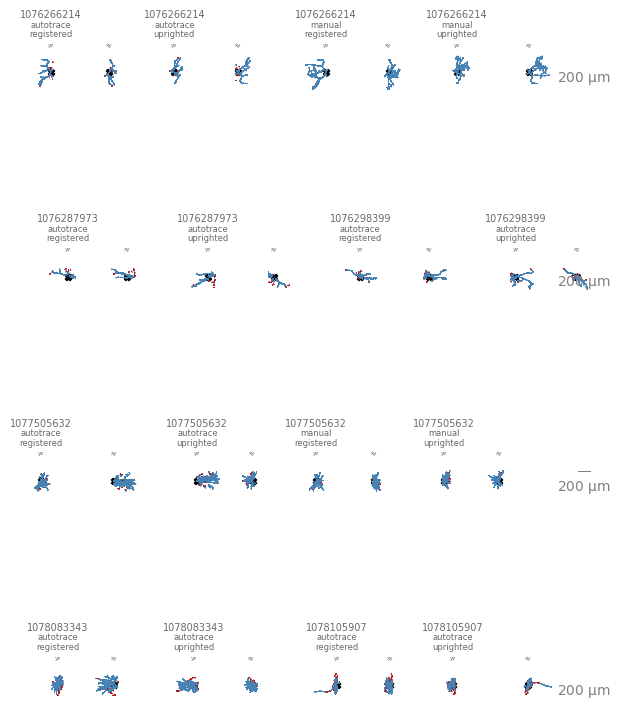

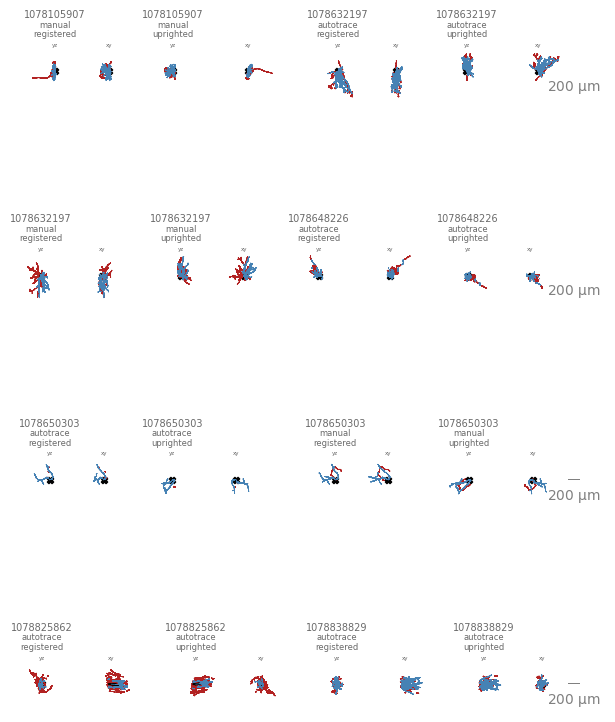

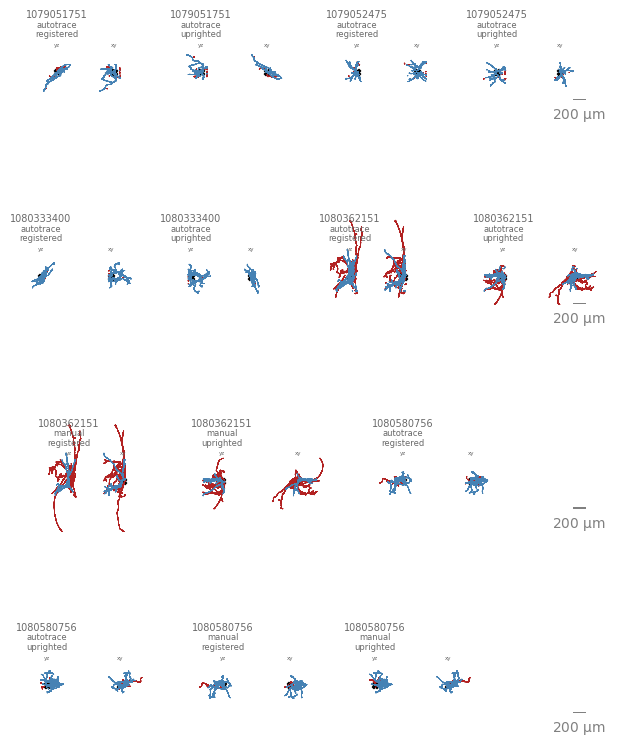

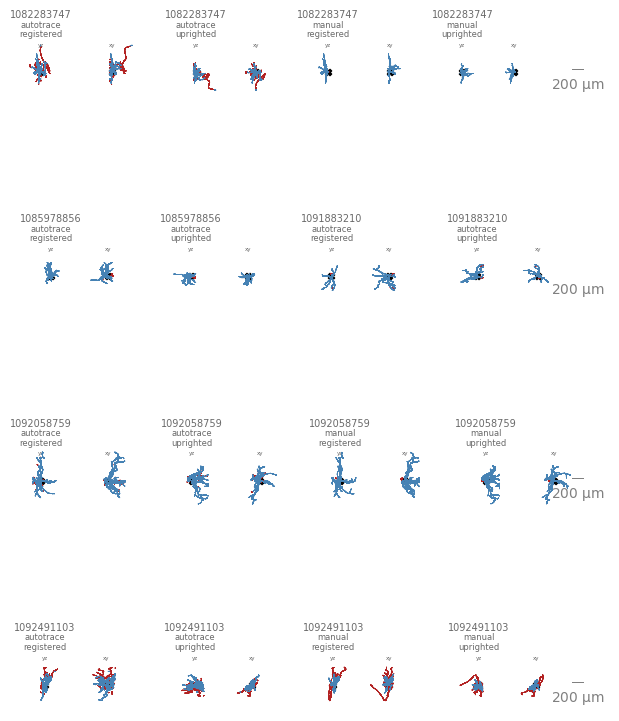

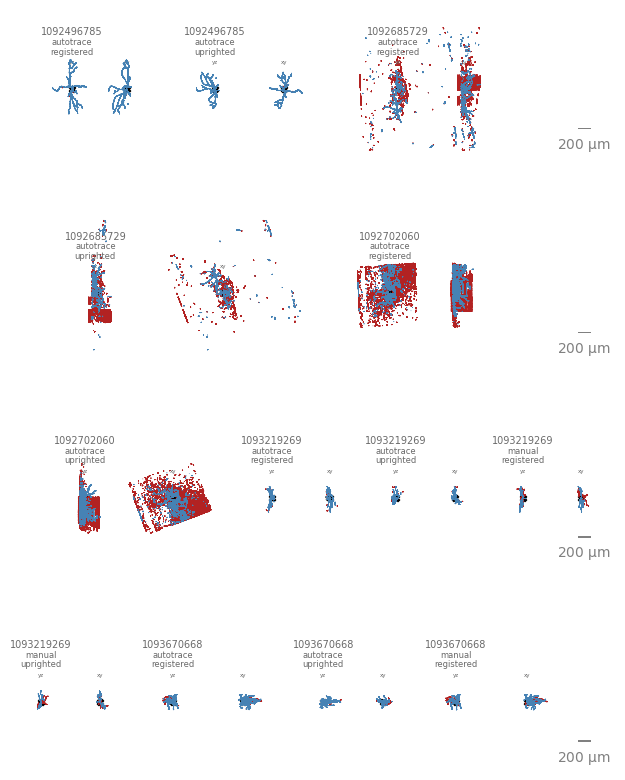

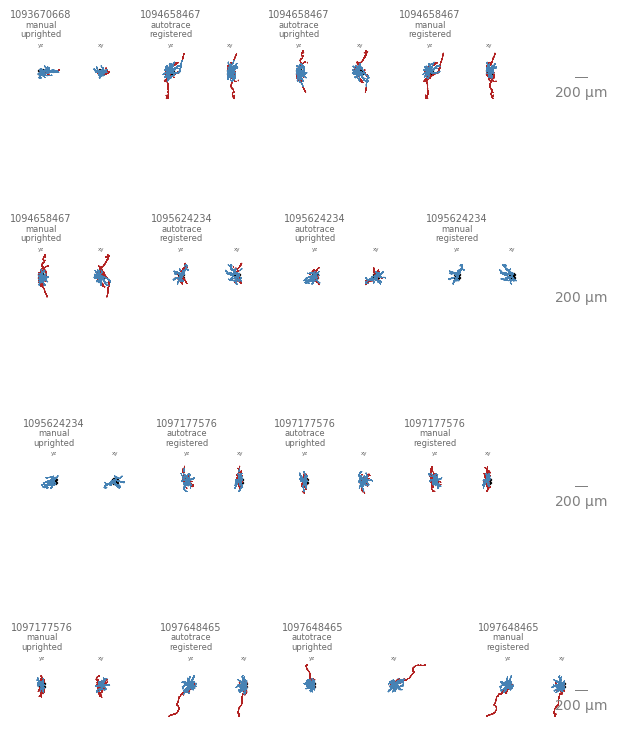

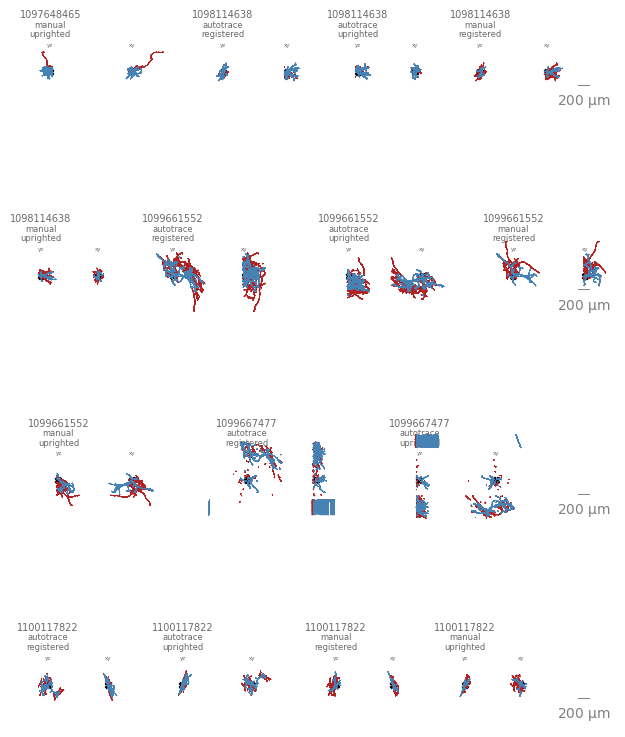

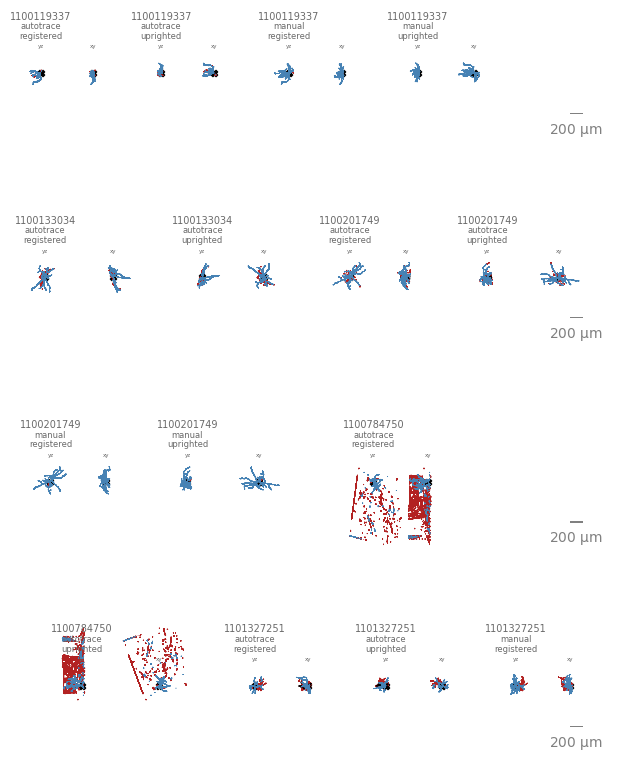

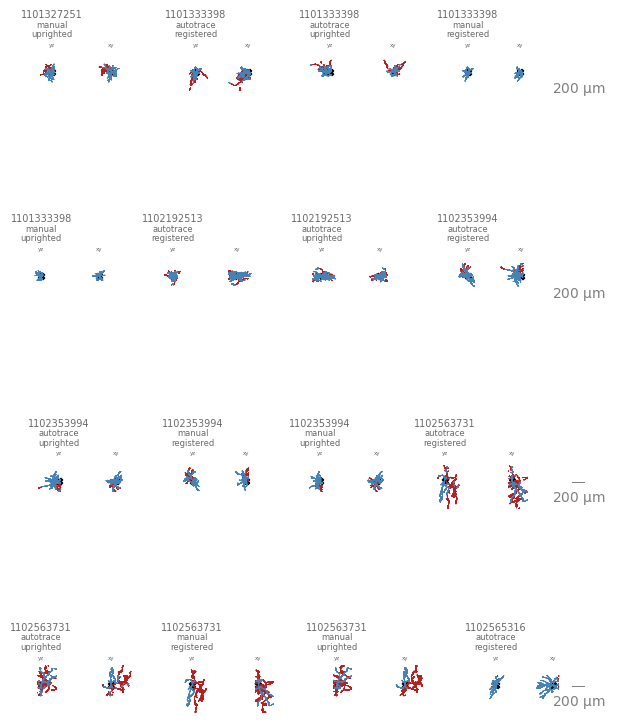

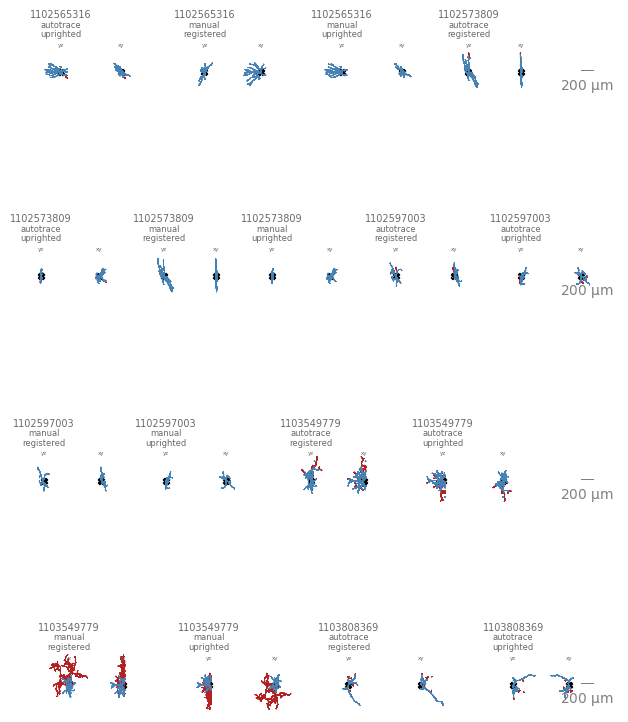

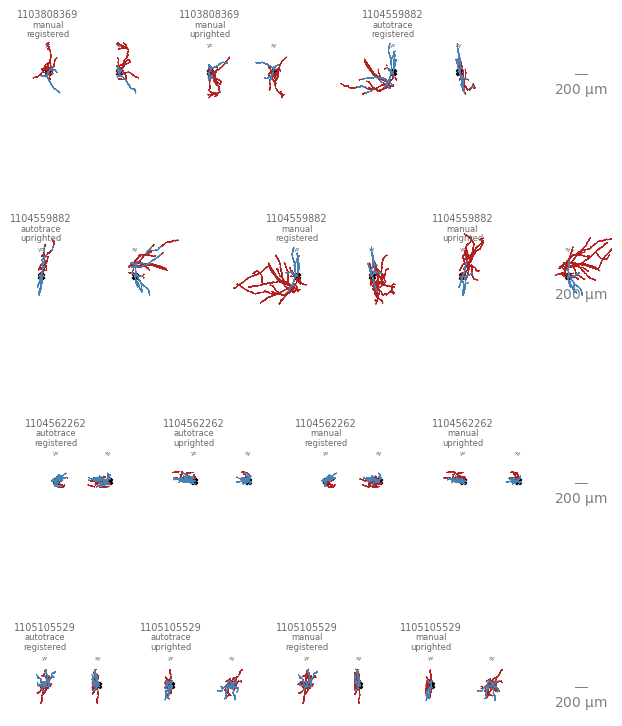

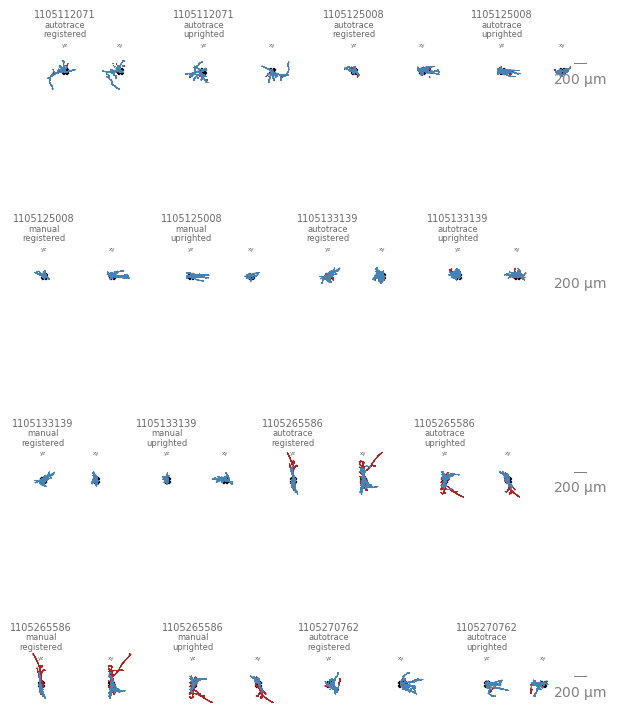

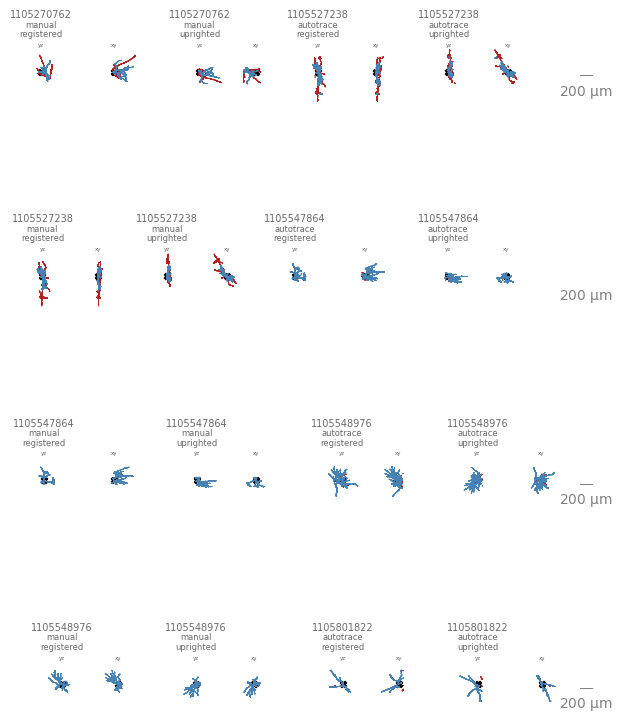

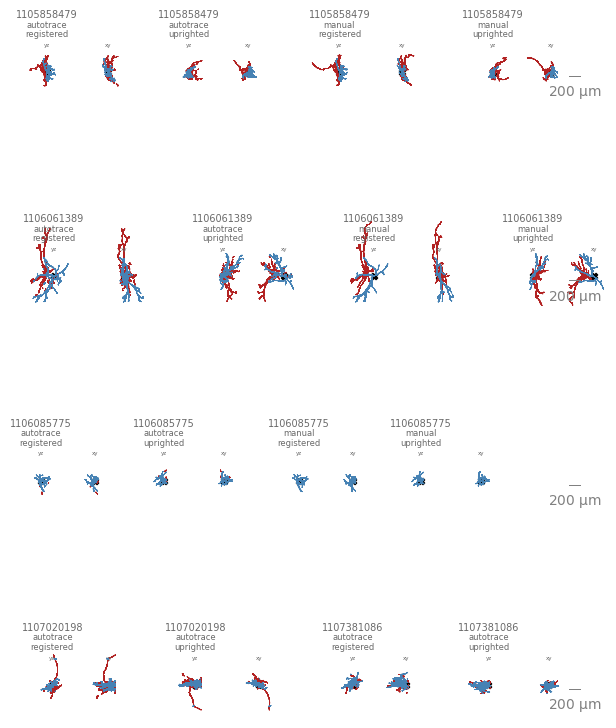

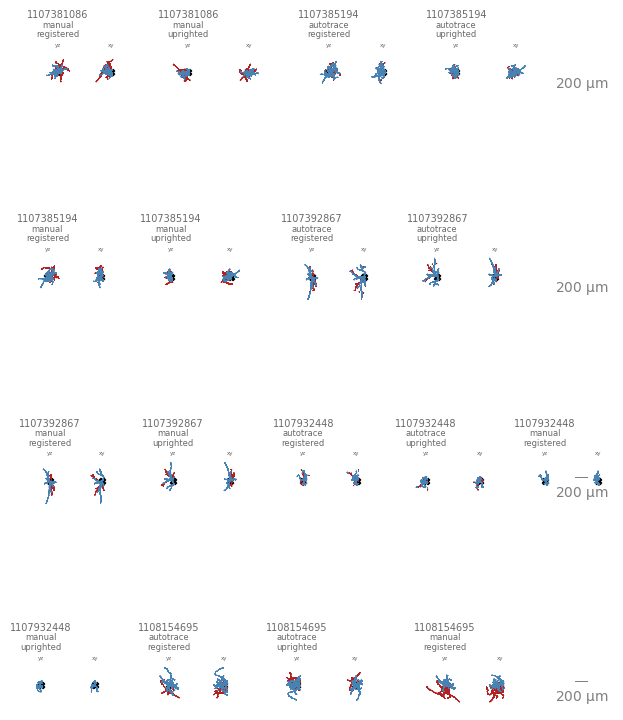

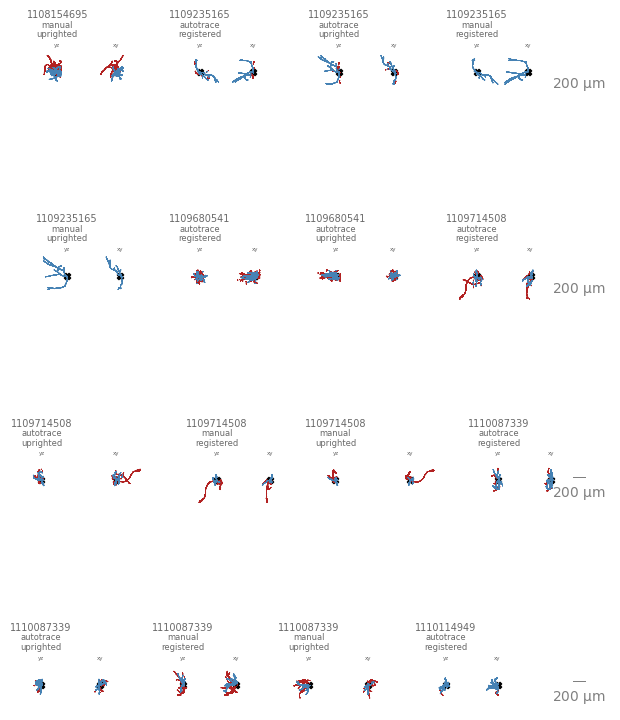

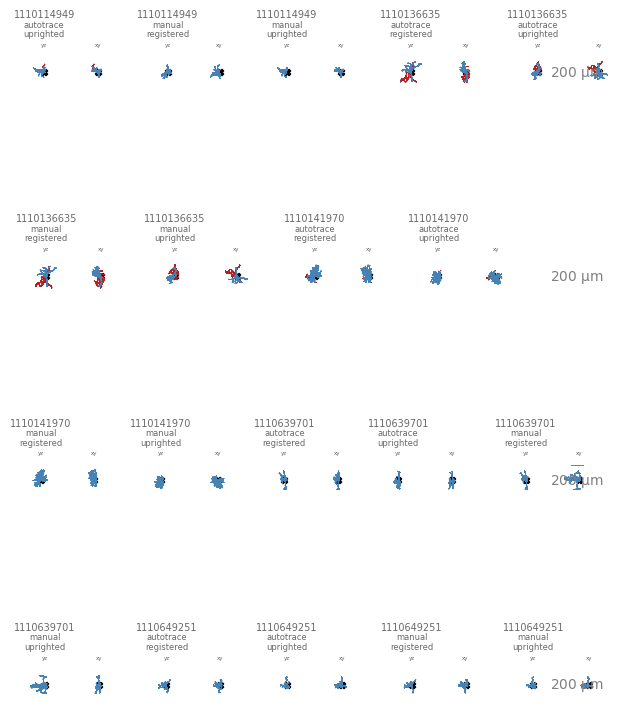

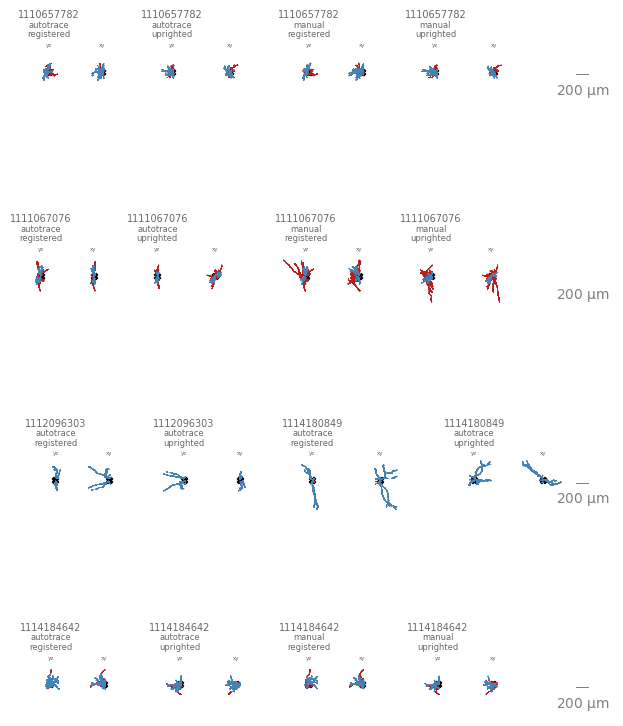

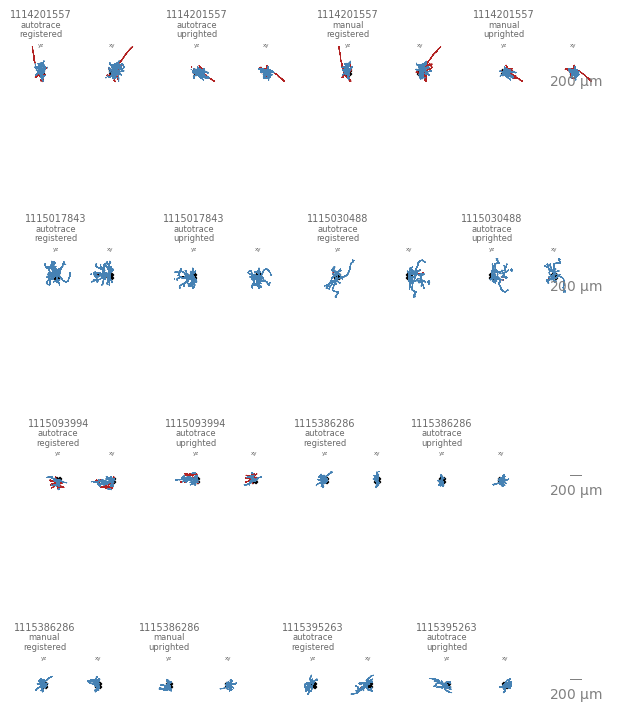

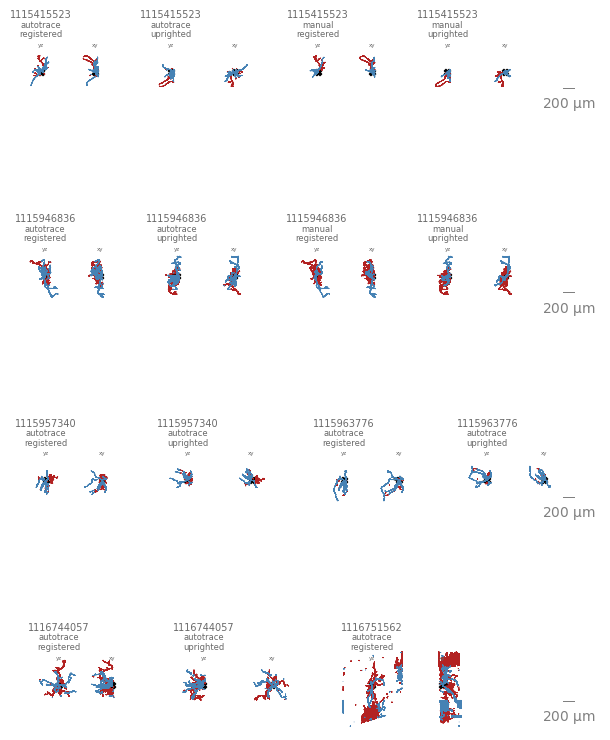

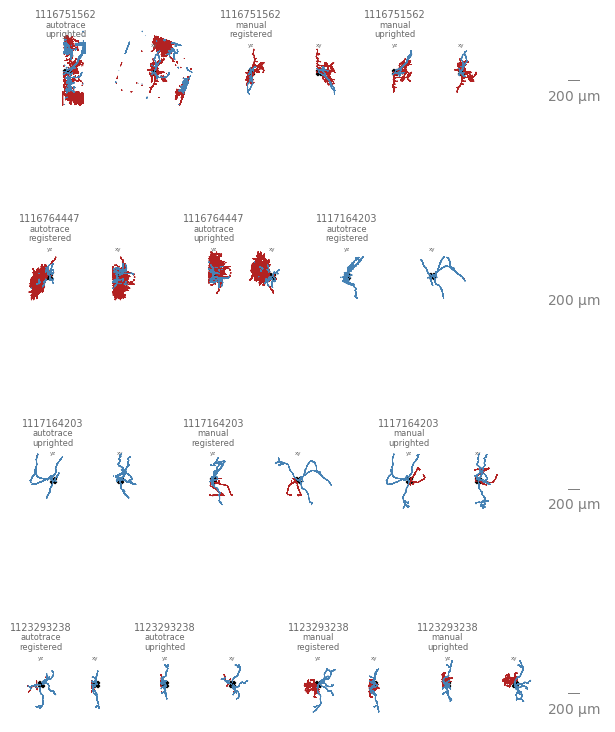

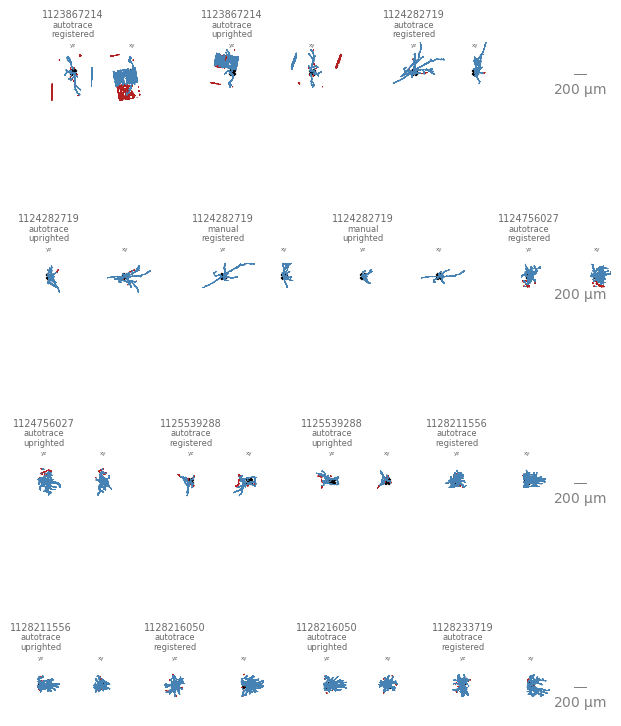

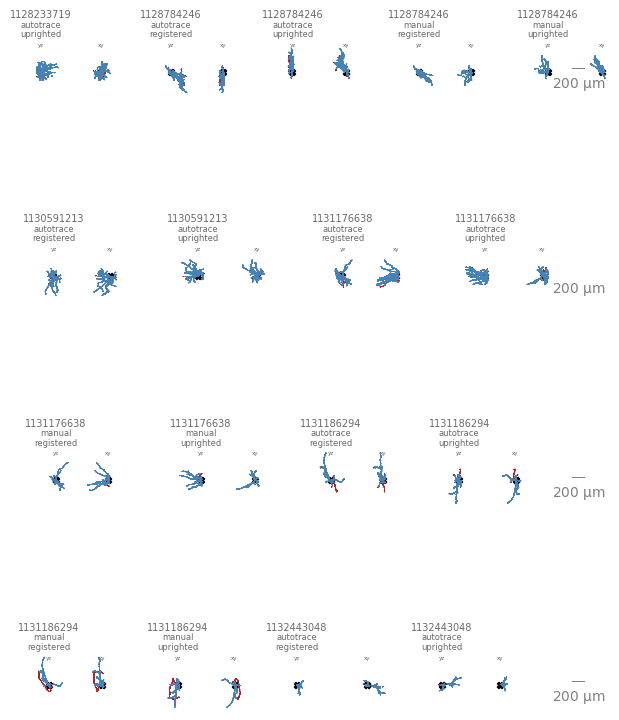

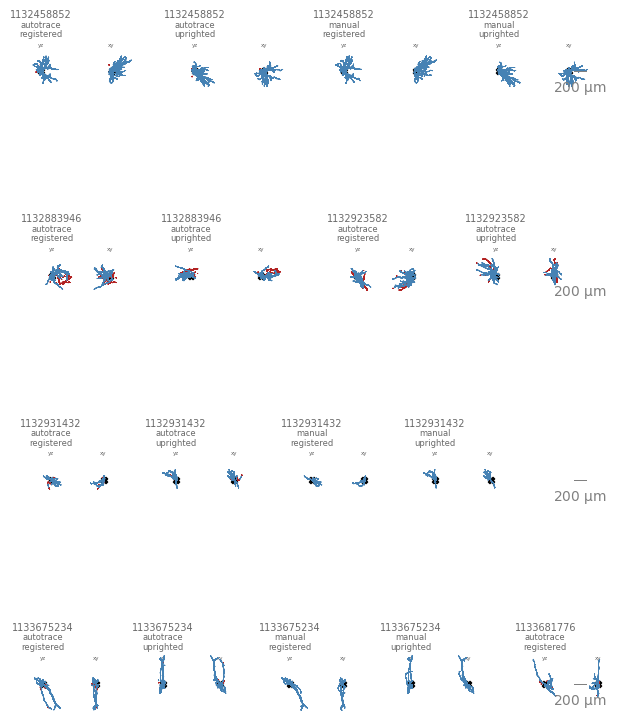

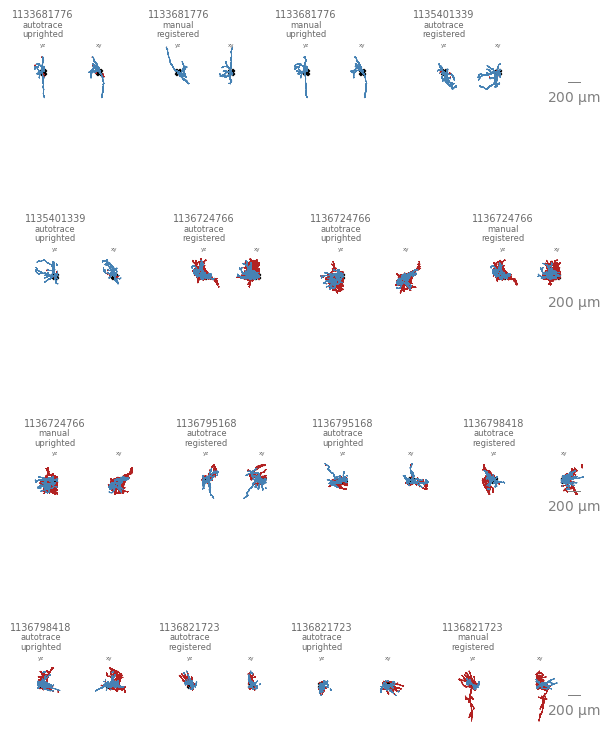

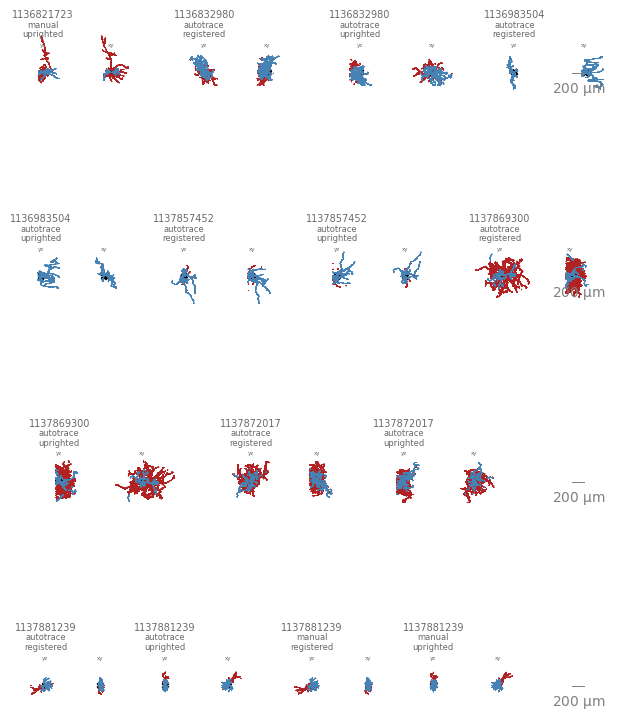

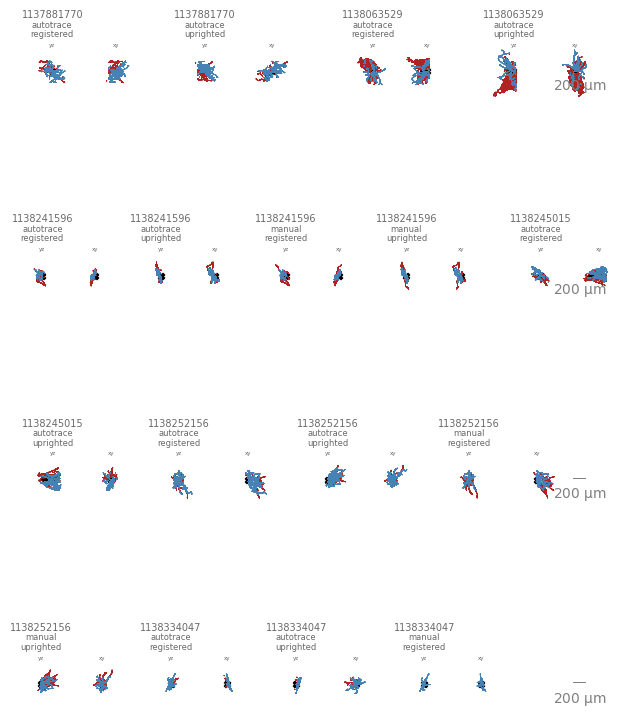

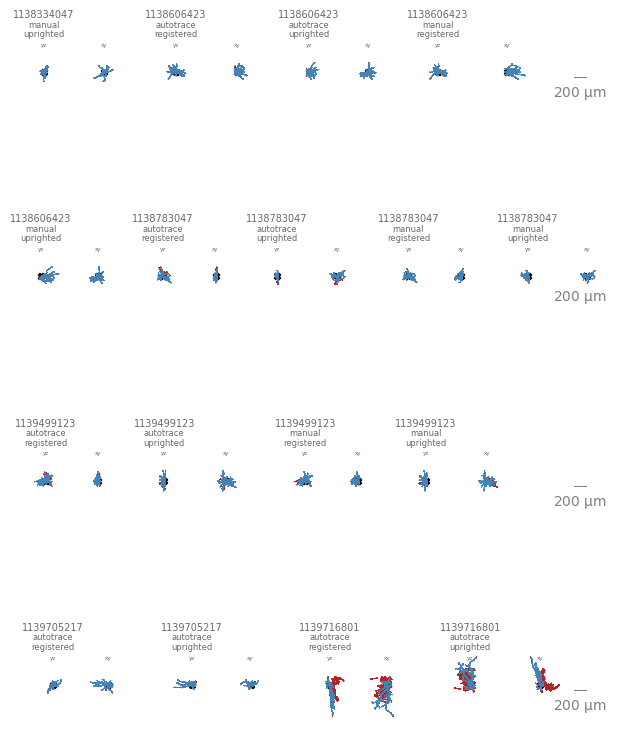

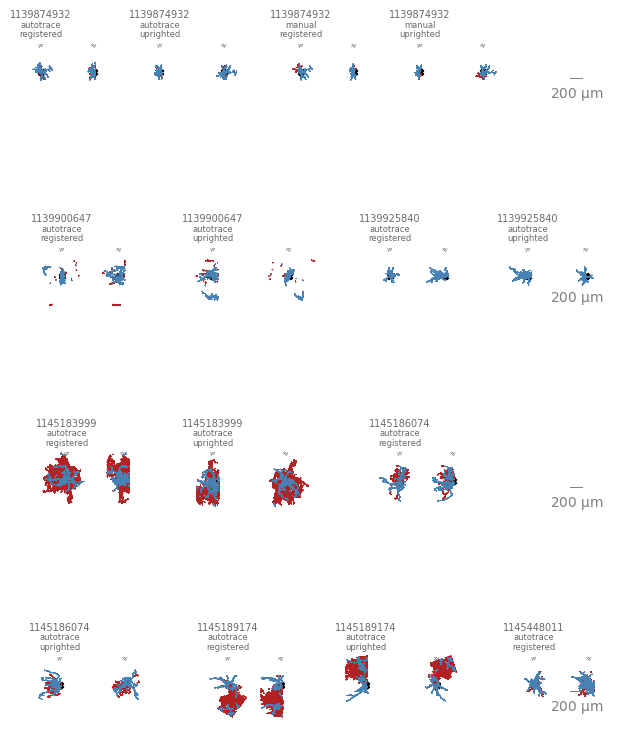

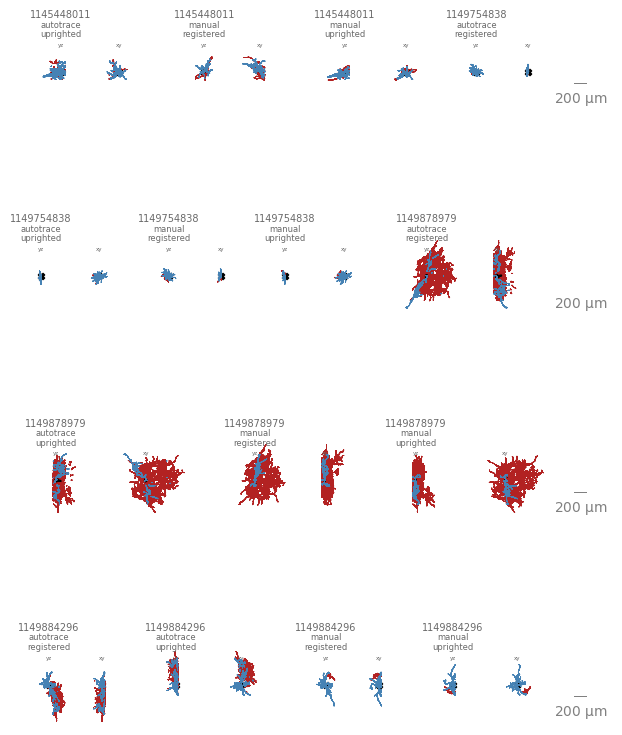

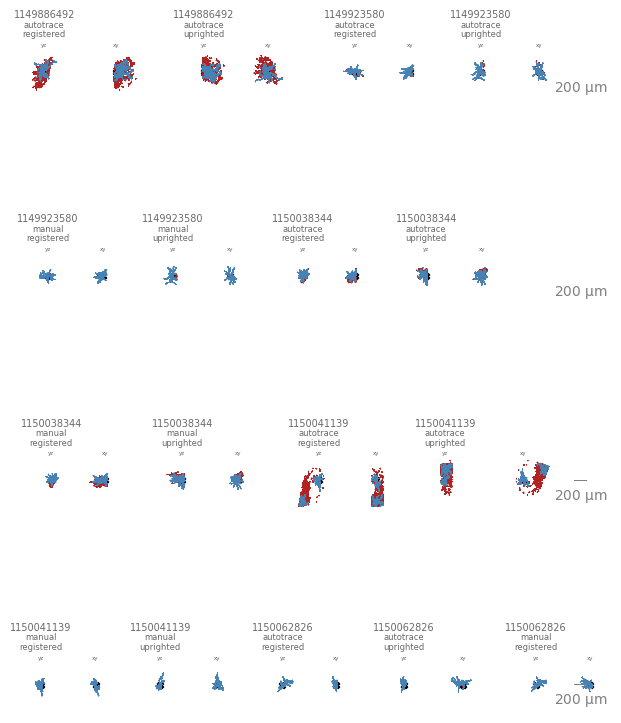

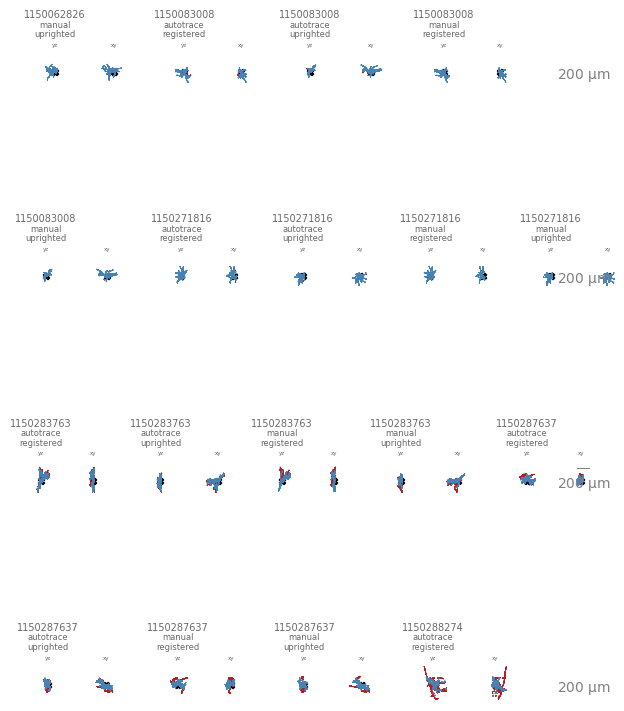

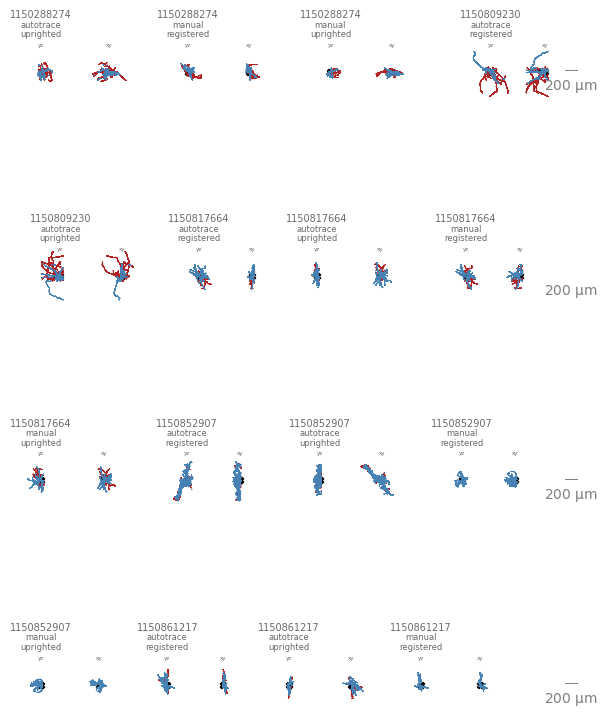

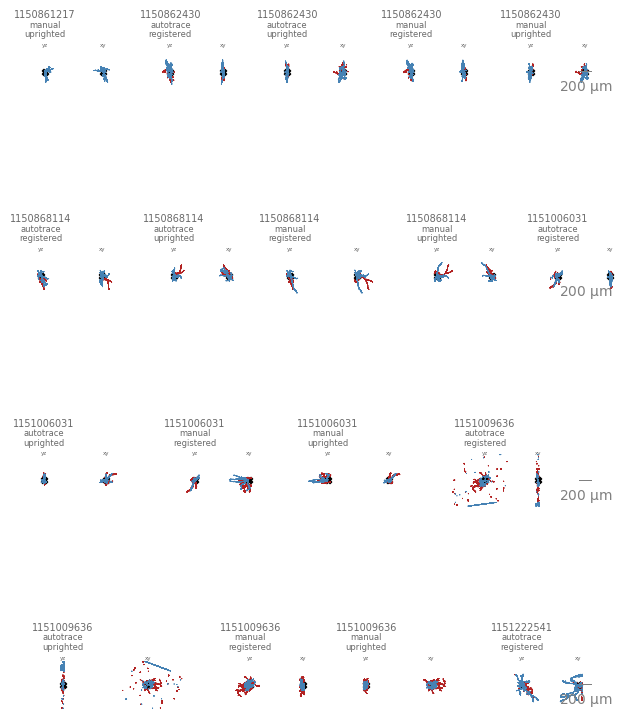

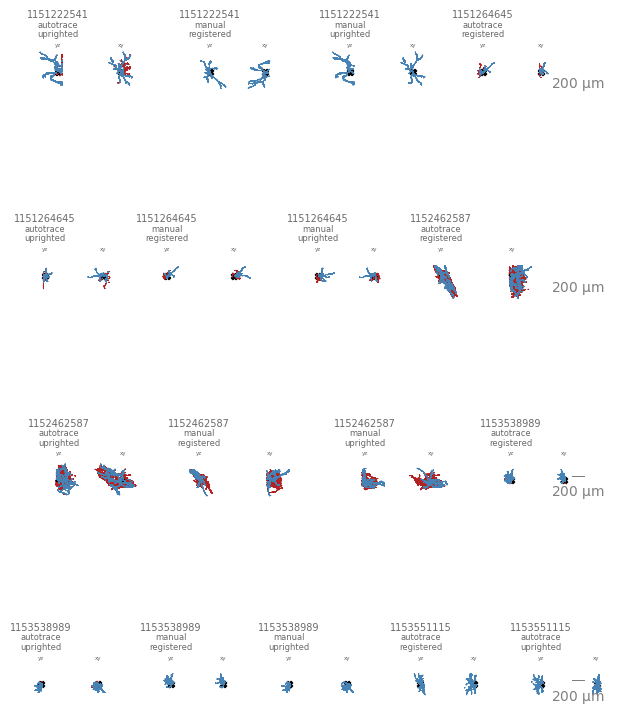

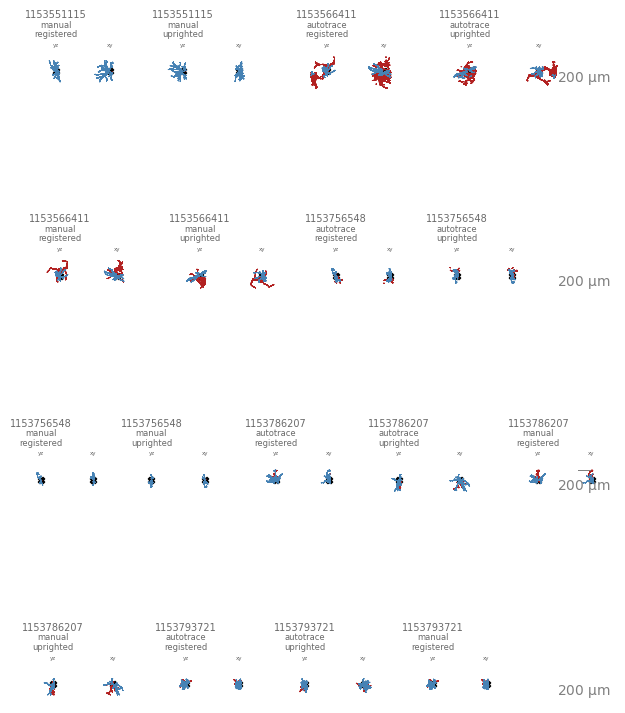

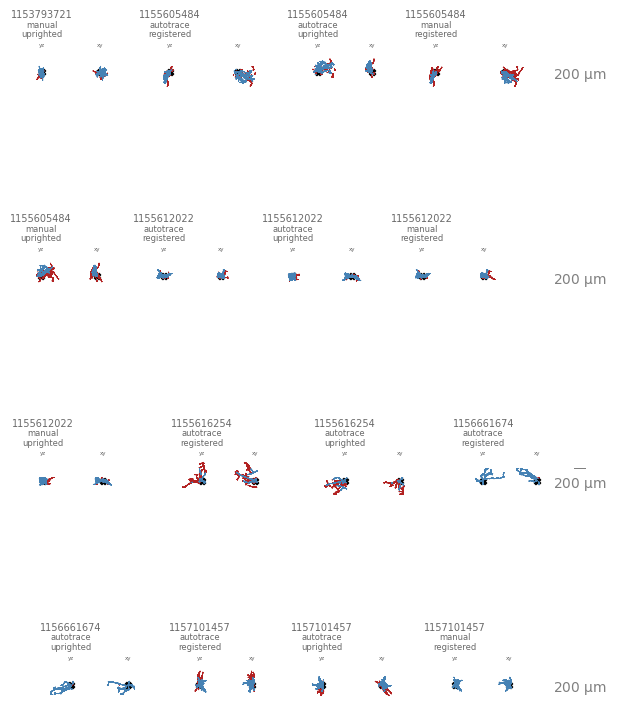

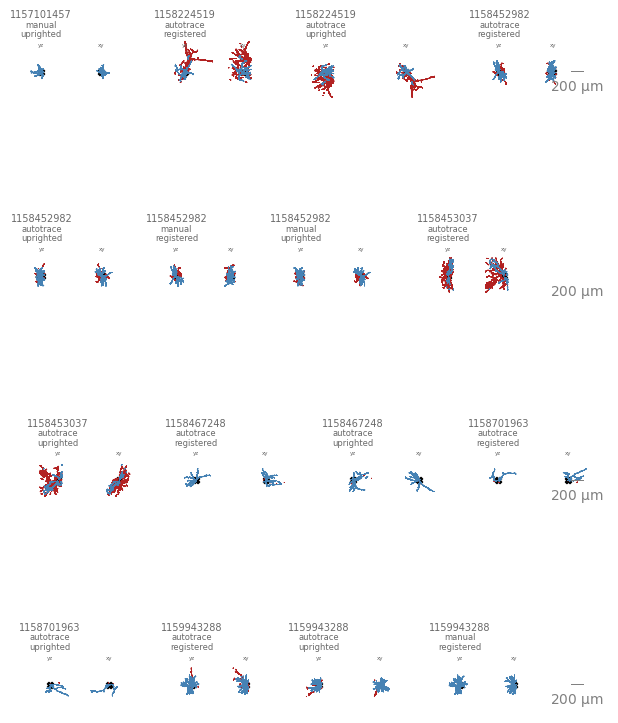

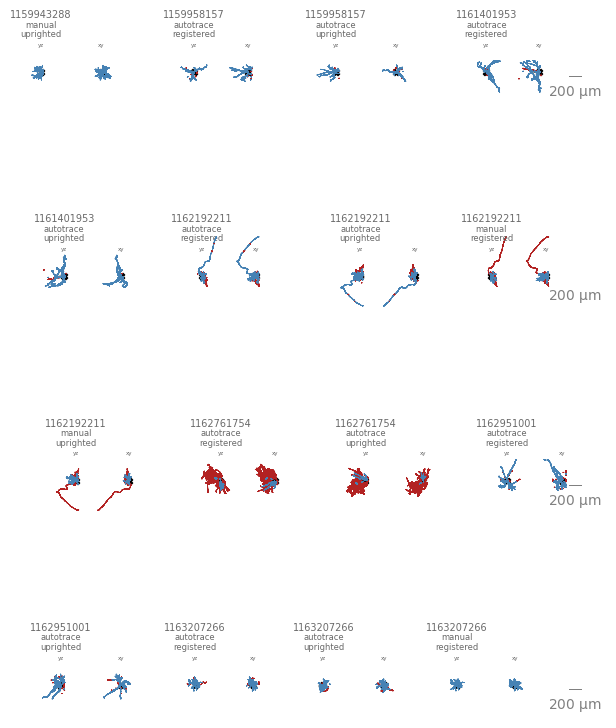

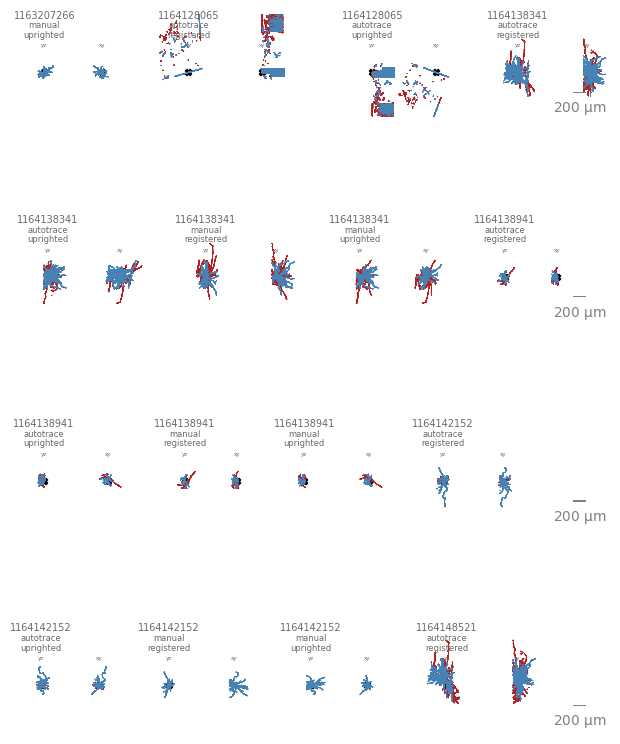

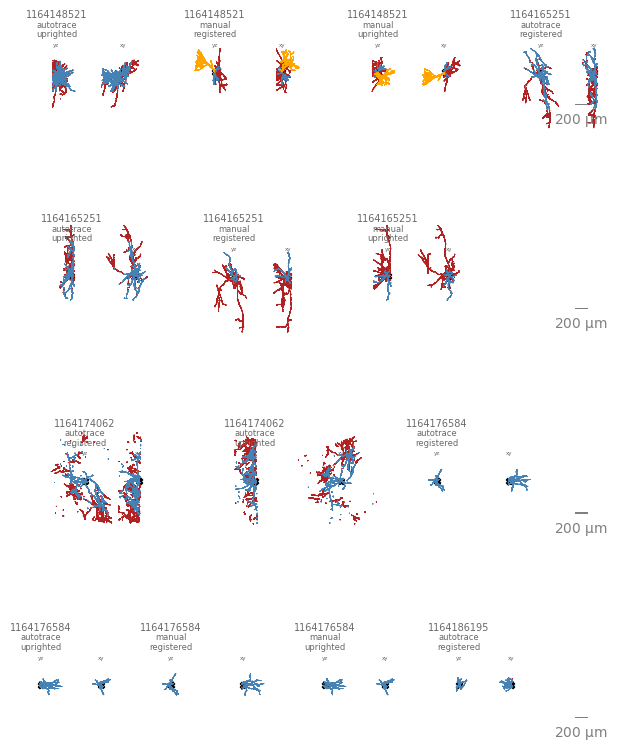

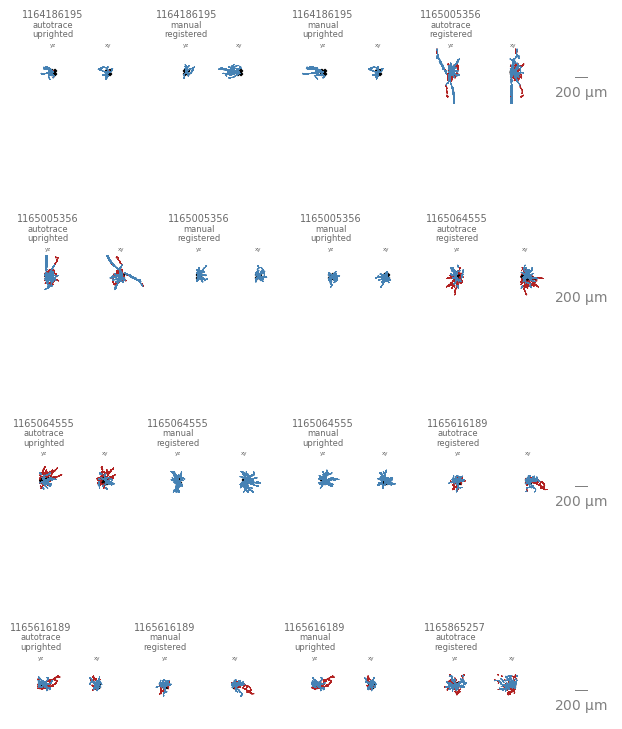

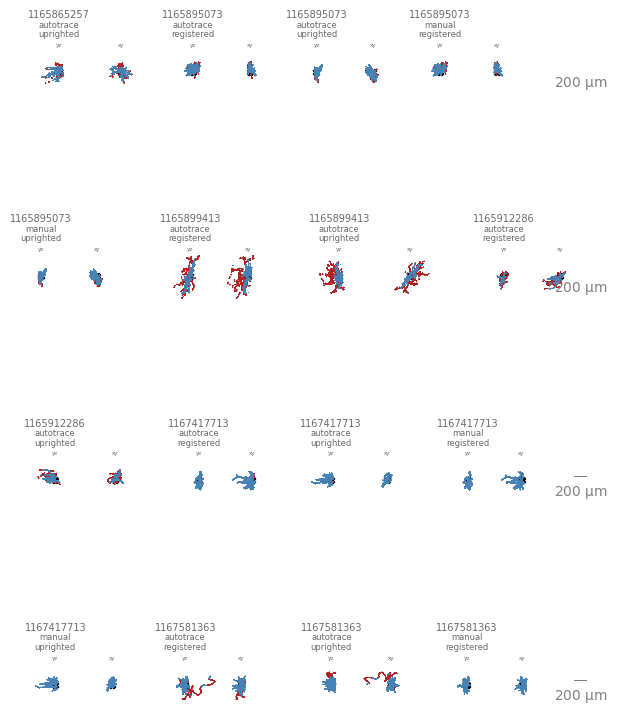

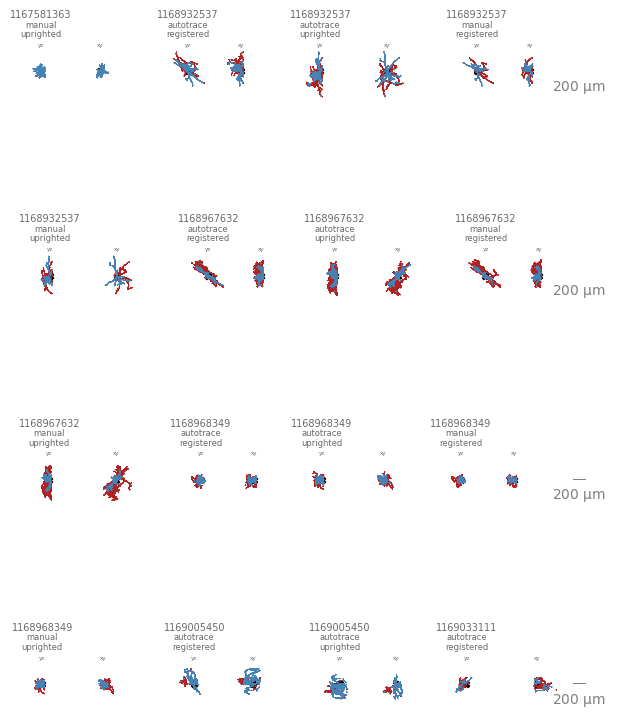

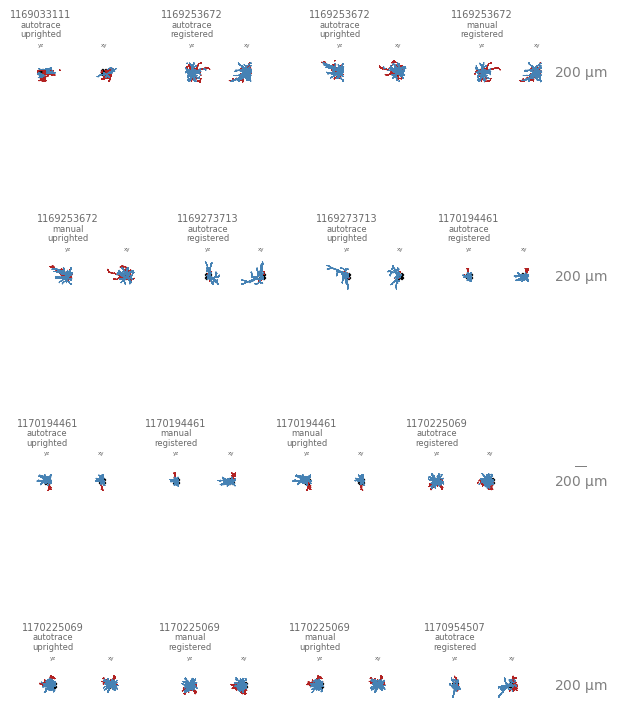

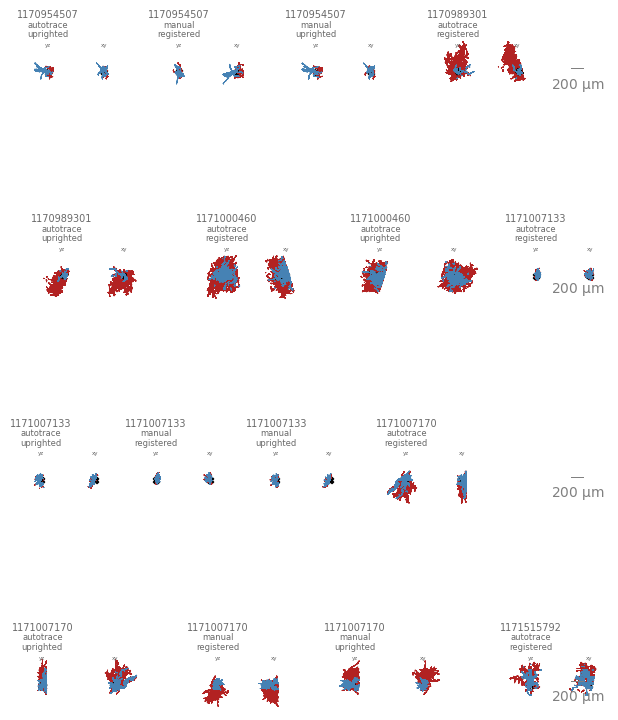

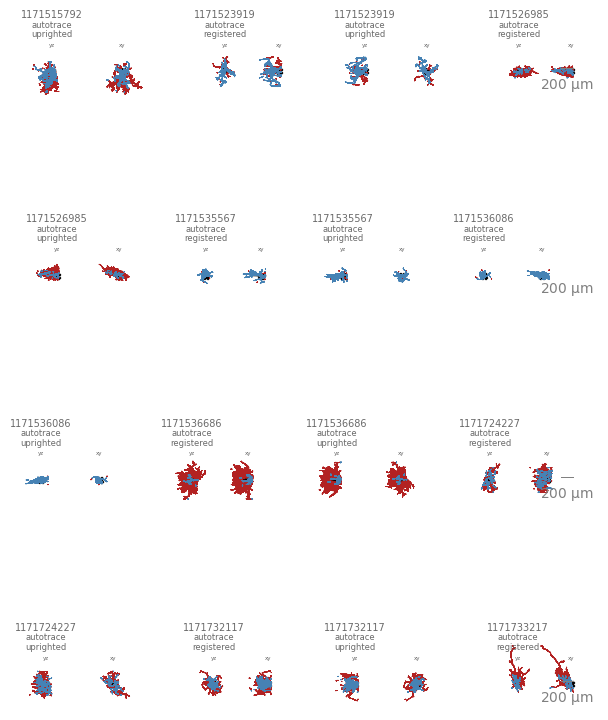

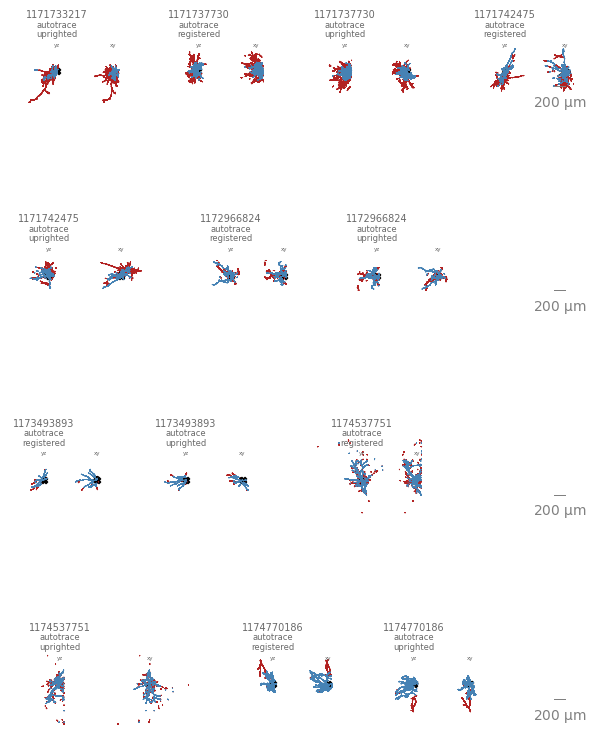

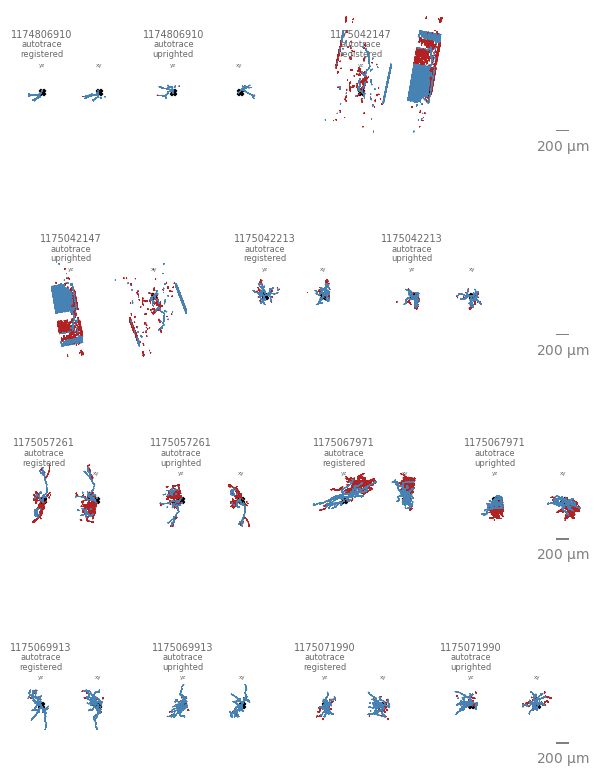

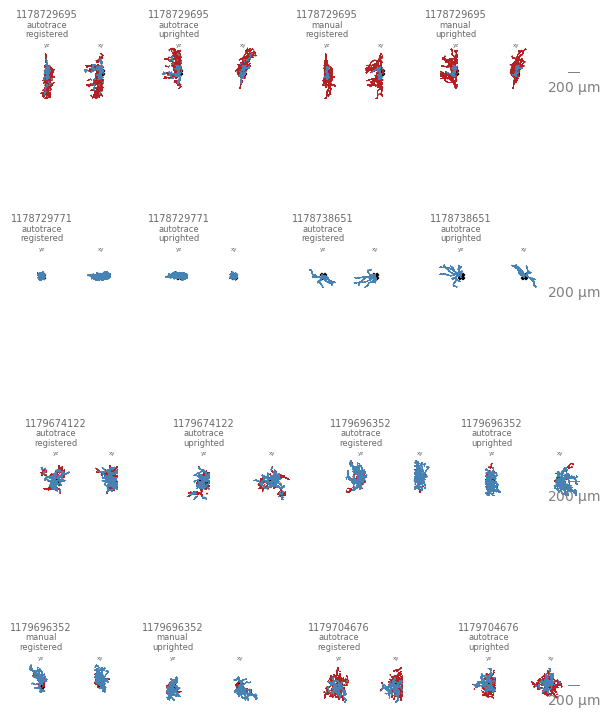

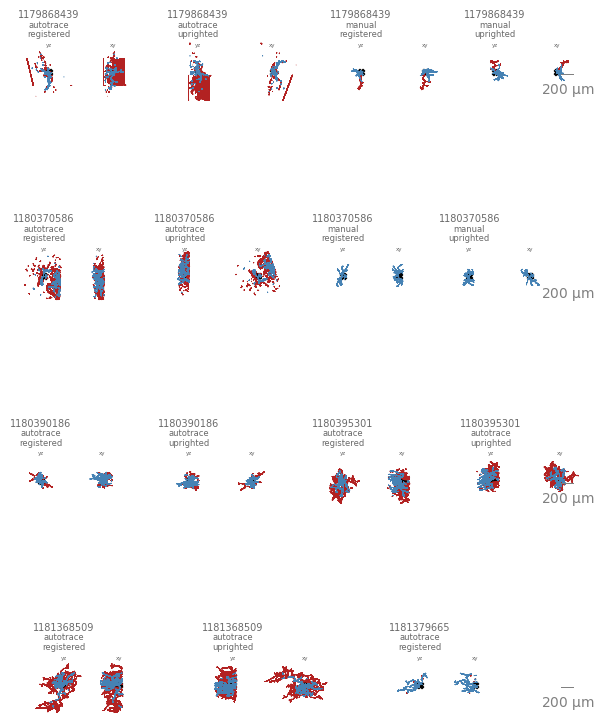

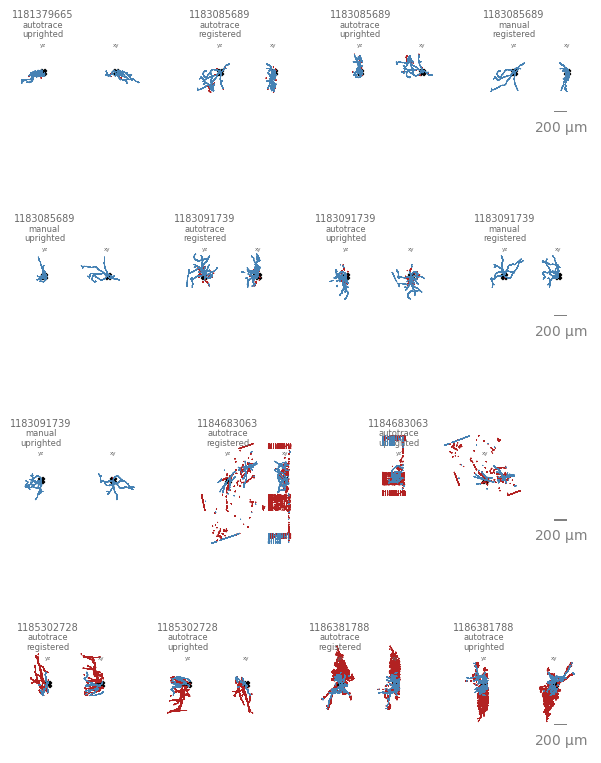

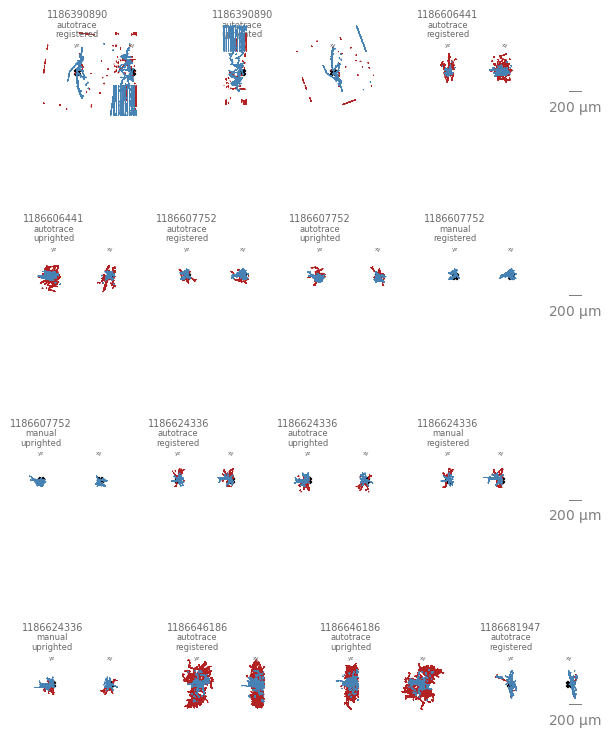

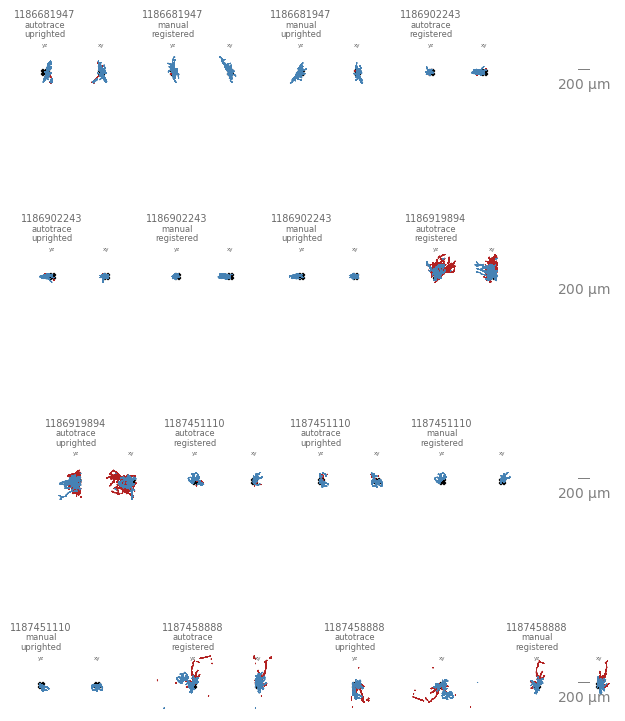

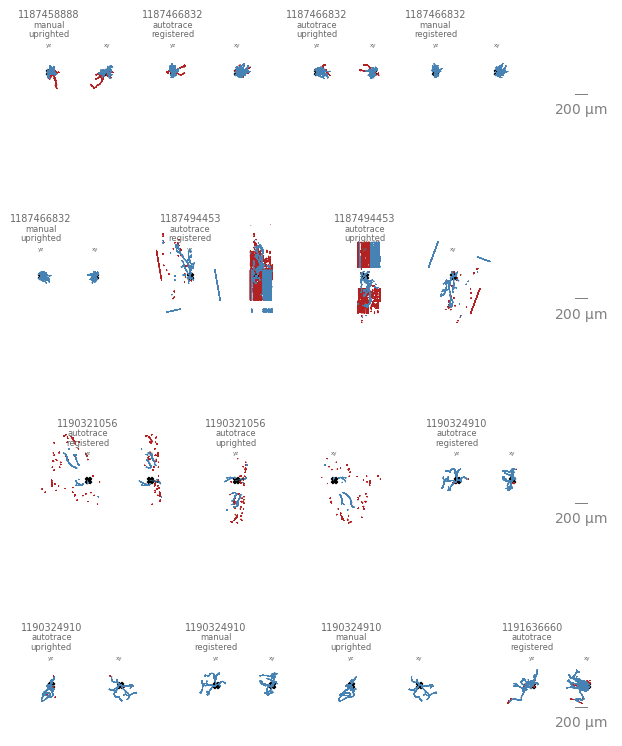

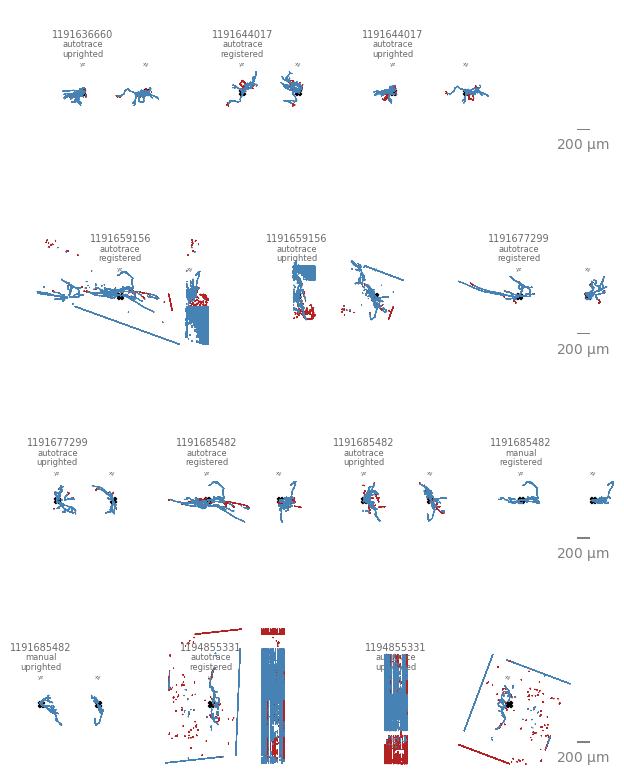

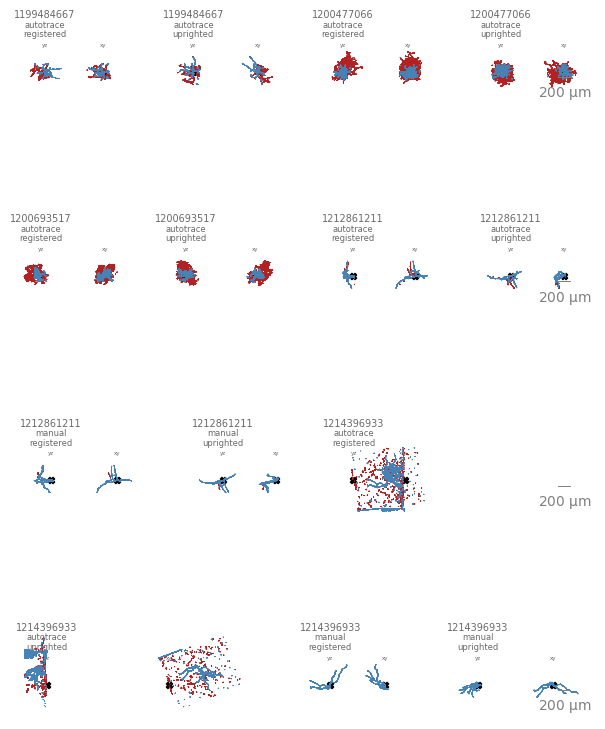

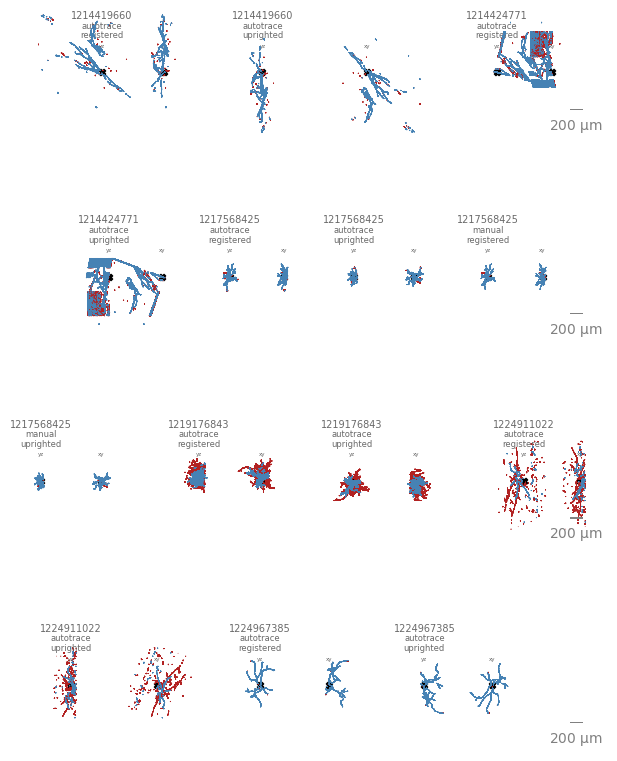

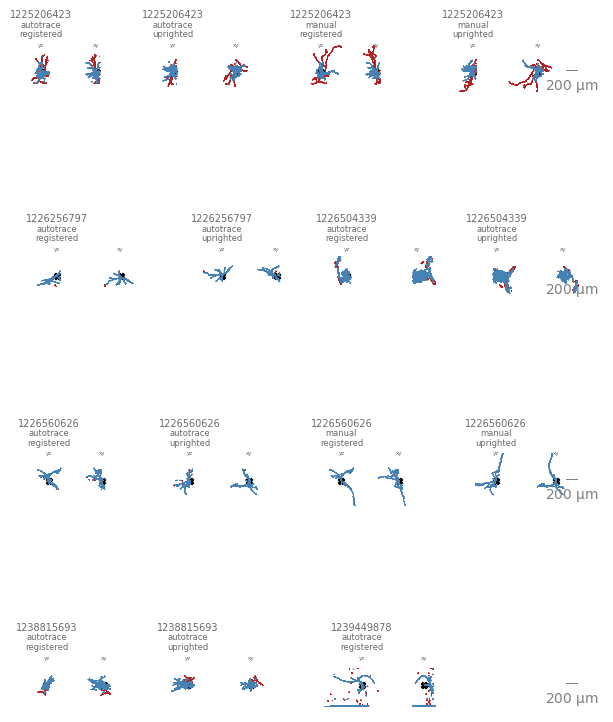

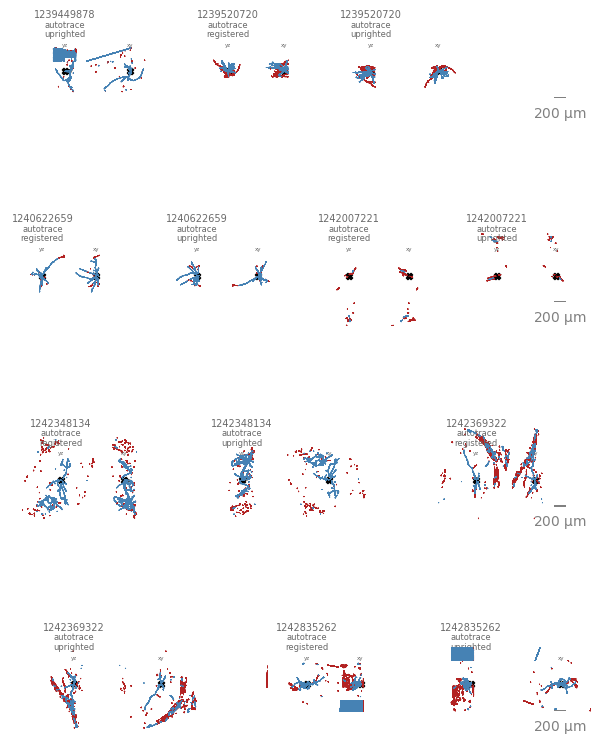

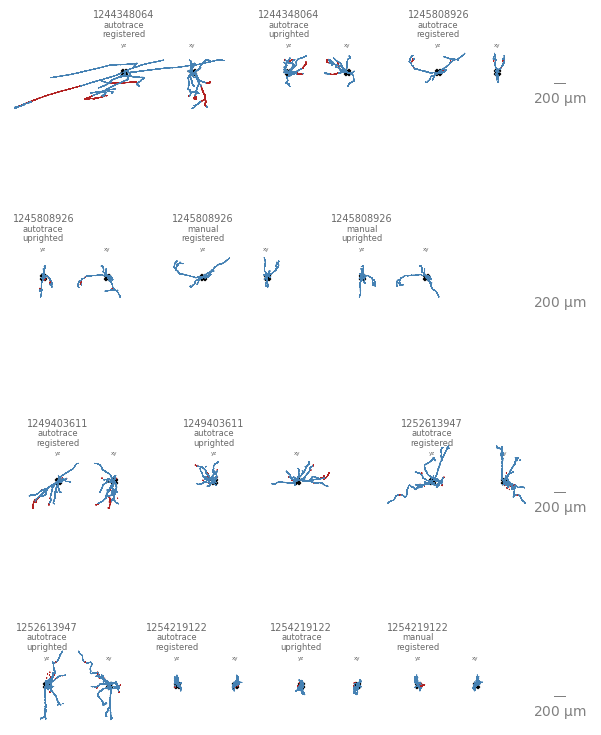

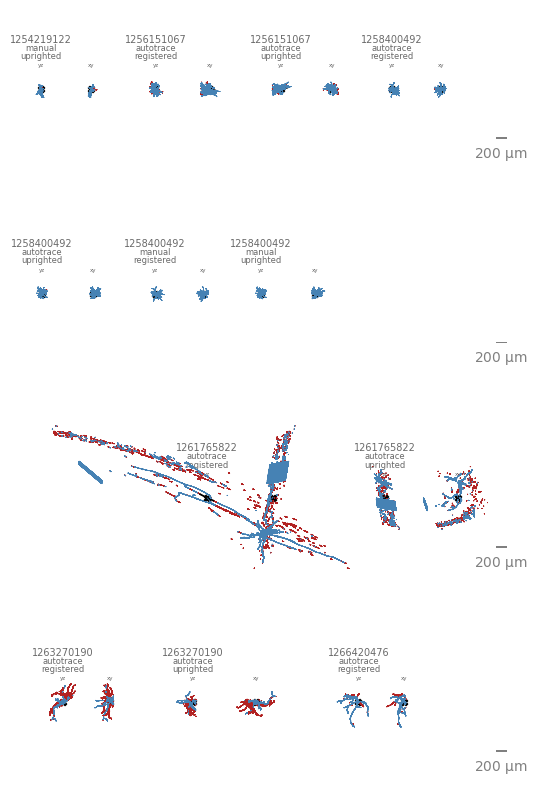

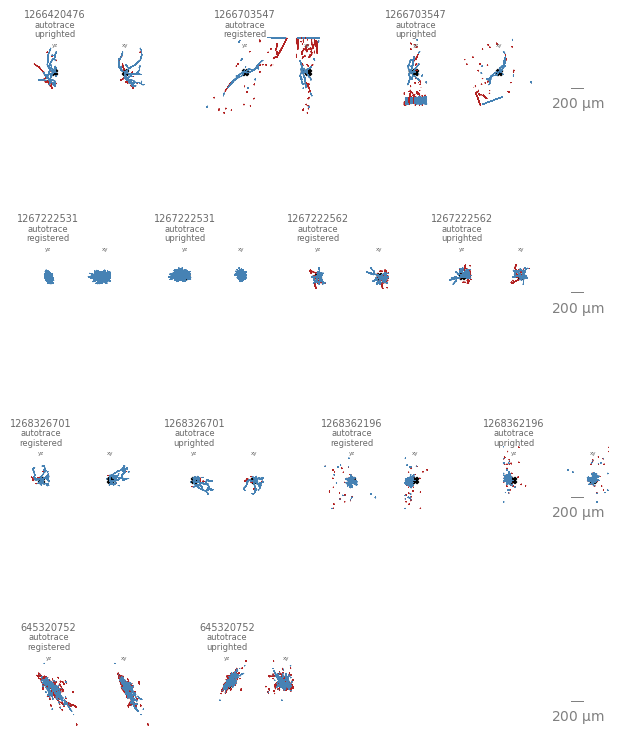

<Figure size 640x480 with 0 Axes>

In [7]:
#make pdf viewer

#formatting vars for tinkering 

cell_title_start_height = 1000 #starting height for cell title 
cell_title_vertical_space = 150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)


    sps_list = sorted(list(viewer_cells.keys()))
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=800
    with PdfPages(viewer_outfile) as pdf:
        while sps_list != []:
            #one fig per page, each has page (fig) has 8 rows. 
            fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(7.5,10),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},
            for ax in axes: #plot as many neurons as fit on this page (num_rows rows of plotting)

                ax.axis('off')
                ax.set_xlim(0,9100) #sets a xlim (width limit) per cell
                lim = 9000
                xloc = 0
                xoffset = 0
                ax.set_anchor('W')

                while xloc < lim: #plot as many neurons as fit on this plot (layer row)
                    if sps_list != []:
                        sp = sps_list.pop() #the specimen to plot
                        
                        # get data for this specimen
                        specimen_id = viewer_cells[sp]['specimen_id']
                        swc_path = viewer_cells[sp]['swc_path']
                        slice_id = viewer_cells[sp]['slice_id']
                        slice_name = viewer_cells[sp]['slice_name']
                        reg_type = viewer_cells[sp]['reg_type']
                        swc_type = viewer_cells[sp]['swc_type']

                        # title
                        sp_title = [str(specimen_id), swc_type, reg_type]
                        
                        cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                        morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                        
                        # get the layer-aligned file
                        nrn = morphology_from_swc(swc_path)
                        try: 
                            nrn = normalize_position(nrn)
                        except: 
                            print('cell {} has an error with the soma type: {}'.format(specimen_id, swc_path))

                        try: 
                            xoffset += leftextent(nrn,compartment_list)
                            xoffset += inextent(nrn,compartment_list)
                            if xoffset+rightextent(nrn,compartment_list)+buffer>lim: #if gone over page width limit for this row, pop cell back on list and go to next plotting row
                                sps_list = sps_list + [sp]
                                break
                            else:
                                
                                y = cell_title_start_height #plot cell title 
                                i = 0
                                for l in sp_title:
                                    y-=cell_title_vertical_space
                                    ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                                    i+=1

                                y-=cell_title_vertical_space
                                for s in plot_side:
                                    if s: v = 'yz'
                                    else: v = 'xy'
                                    ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                                    basic_morph_plot(nrn,morph_colors=morph_colors, 
                                                ax=ax, xoffset=xoffset,side=s)
                                    xoffset += rightextent(nrn,compartment_list)
                                    xoffset += buffer

                            if xloc == 0:
                                #add a scale bar 
                                scalebar = ScaleBar(1, "um", location='lower right', frameon=False, length_fraction=0.05, color='grey')
                                ax.add_artist(scalebar)

                            xloc=xoffset
                        except: 
                            print('error with cell {}: {}'.format(specimen_id, swc_path))


                    else:
                        break

            for ax in axes:
                ax.set_aspect("equal")
            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()
